With this notebook we train a network to recognize samples of leaves from 13 classes, all the classes except the Tomatoes, that should be recognized in the other network.

In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/

/gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN


In [3]:
!unzip no_tomato.zip

Archive:  no_tomato.zip
replace no_tomato/train/Squash/19003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Imports

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
dataset_dir = 'no_tomato'

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

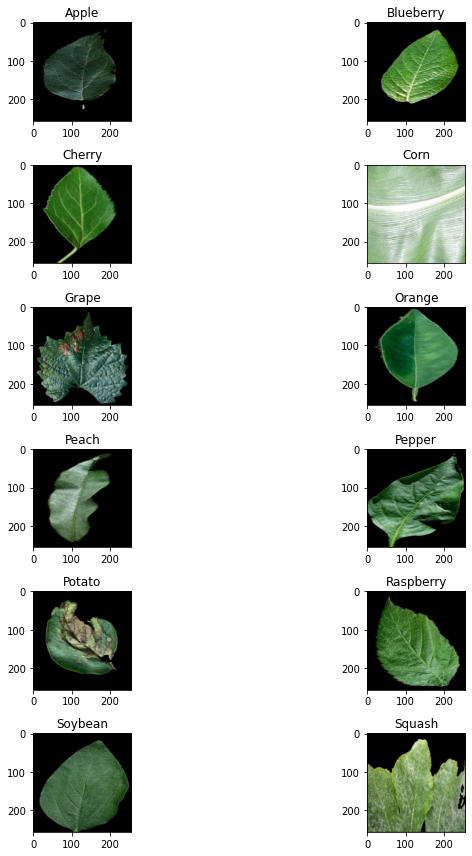

In [7]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))
for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))
    class_imgs = class_imgs[2]
    
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

#Data Generator

Import:

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Create an instance of ImageDataGenerator with NO Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rescale=1/255.)
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=120,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=120,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=120,
                                               shuffle=False,
                                               seed=seed)

Found 9022 images belonging to 13 classes.
Found 1799 images belonging to 13 classes.
Found 1214 images belonging to 13 classes.


#Characteristics

In [10]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

In [11]:
# Model used:
# Network from the exercise classes
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=13, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=[tf.keras.metrics.CategoricalAccuracy(), 'accuracy'])

    # Return the model
    return model

#Building Model

In [12]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

#Training the model

In [ ]:
# Create folders and callbacks and fit
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [early_stopping],
).history

Epoch 1/200
76/76 [==============================] - 5029s 66s/step - loss: 1.4141 - accuracy: 0.5546 - val_loss: 0.9303 - val_accuracy: 0.7048
Epoch 2/200
76/76 [==============================] - 41s 534ms/step - loss: 0.6660 - accuracy: 0.7867 - val_loss: 0.5172 - val_accuracy: 0.8271
Epoch 3/200
76/76 [==============================] - 40s 530ms/step - loss: 0.4235 - accuracy: 0.8608 - val_loss: 0.4366 - val_accuracy: 0.8599
Epoch 4/200
76/76 [==============================] - 40s 530ms/step - loss: 0.2393 - accuracy: 0.9226 - val_loss: 0.3097 - val_accuracy: 0.9027
Epoch 5/200
76/76 [==============================] - 40s 529ms/step - loss: 0.1626 - accuracy: 0.9435 - val_loss: 0.4024 - val_accuracy: 0.8794
Epoch 6/200
76/76 [==============================] - 40s 526ms/step - loss: 0.1101 - accuracy: 0.9629 - val_loss: 0.2559 - val_accuracy: 0.9261
Epoch 7/200
76/76 [==============================] - 40s 519ms/step - loss: 0.0911 - accuracy: 0.9686 - val_loss: 0.3135 - val_accuracy:

#Saving the model

In [ ]:
# Save best epoch model
model.save("First_Run_")

INFO:tensorflow:Assets written to: First_Run/assets


INFO:tensorflow:Assets written to: First_Run/assets


#Plot training error and validation error

{'loss': [1.414084792137146, 0.6660489439964294, 0.4235366880893707, 0.23928789794445038, 0.16257303953170776, 0.11006192862987518, 0.09113647788763046, 0.06834474951028824, 0.05908762663602829, 0.05049555003643036, 0.045750927180051804, 0.034990474581718445, 0.048015713691711426, 0.024263329803943634, 0.017523430287837982, 0.0462510921061039, 0.022302770987153053, 0.01142484787851572, 0.013461768627166748], 'accuracy': [0.5546442270278931, 0.7867435216903687, 0.8607847690582275, 0.9226335883140564, 0.9434714913368225, 0.9628685712814331, 0.9686322212219238, 0.9763910174369812, 0.9813788533210754, 0.9824872612953186, 0.9852582812309265, 0.9883617758750916, 0.9858124852180481, 0.9925737380981445, 0.9946796894073486, 0.9869208335876465, 0.9932387471199036, 0.9963423013687134, 0.9958989024162292], 'val_loss': [0.9303236603736877, 0.5171549916267395, 0.43662407994270325, 0.3096807599067688, 0.40235164761543274, 0.2558636963367462, 0.313539981842041, 0.3131333291530609, 0.27212825417518616,

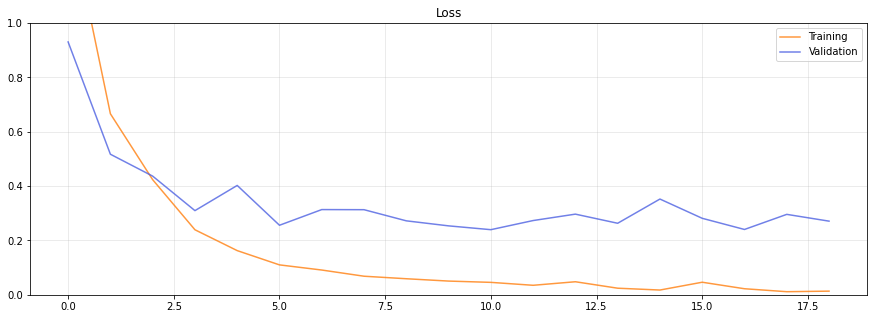

In [ ]:
print(history)
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Show predictions

In [13]:
model_others = tfk.models.load_model("First_Run_Others")

In [14]:
print(test_gen.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12}


In [15]:
model_metrics = model_others.evaluate(test_gen, return_dict=True)

11/11 [==============================] - 392s 38s/step - loss: 0.2084 - accuracy: 0.9349
